In [1]:
import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')

import gw150814_simulator as gs
# import module

import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()

import matplotlib.pyplot as plt

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Simulations and Utils
## Creating some distorted data
Let us start by defining some data using an additive simulator. Note that we want 100,000 samples of data here, 100 bins (indicated by the blue points), and we set ourselves a likelihood covariance of 1 - this noise is sampled along the standard normal distribution.

In order to understand what is going on, we first should understand what `Simulator_Additive` actually produces.

- Theta is the latent parameters of the signal generated, which we generate by sampling from a normal distribution.
- Mu is actually the signal (the mean over the sample) and is evaluated over the `grid` using the expectation of `theta`
- x0 is the observed clean data under the null hypothesis, and is mu with some perturbed gaussian noise, as expected by $H_0$
- ni is the pertubation boolean mask which tells us whether there is an epsilon pertubation on the grid at that point or not
- Epsiolin are the individual additive pertubations, sampled from random standard normal noise; they exist at distinct points on the grid.
- xi is the perturbed signal with the epsilon values added - it is the alterative hypothesis realised.

NOTE: This block produces random data at each point.

True

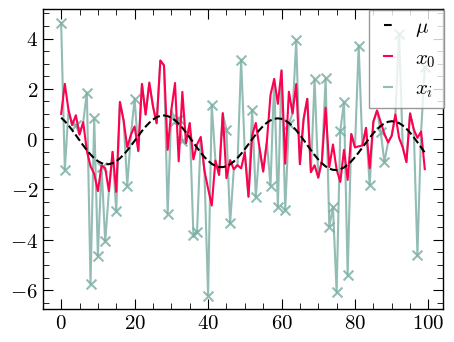

In [2]:
Nsims = 100_000
Nbins = 100
SIGMA = 1
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.5, bkg=True, dtype=torch.float32, device='mps')     
samples = simulator.sample(Nsims=Nsims)

fig, ax1 = pf.create_plot(size=(4,3))

ax1.plot(samples['mu'][0].cpu(), label=r'$\mu$', c='k', ls='--', zorder=10)
ax1.plot(samples['x0'][0].cpu(), label='$x_0$',color='#ff004f', zorder=9)
ax1.plot(samples['xi'][0].cpu(), label='$x_i$', color='#77aca2', alpha=.8)
idx = torch.where(samples['ni'][0] != 0)
ax1.scatter(idx[0].cpu(), (samples['xi'][0].cpu())[idx[0].cpu()], marker='x', s=50, color='#77aca2', alpha=.8)
fig.legend()
pf.fix_plot([ax1])


## Analytical Utils
Next we want a maxmimum likelihood estimation (MLE) of the data, so that we can compare with the network's profiled likelihood. For this we use the function best_fit() from simulator.utils, which simply does a scipy data fit on some model data. Note that each time we take a copy of the dotted line mu, apply some random pertubation from the standard normal, and then best fit these - this then gets plotted each time: we expect the spread across the line to look something like a normal distribution (which it visually does!). Again this is created stochastically so the plot looks different each time.

*Note that this step isn't needed for when we build the pipeline as it is more involved with sampling from a posterior distribution - but shows us the different extent to which we might expect certain samples to have*

## Network and Training

Now we defne our neural network. Note that we are using a 1D U-Net architechture (we are processing 1D data) from Noemi's models script. We define the epsilon training network `Network_epsilon` which has 
- self.net: the 1D U-net that maps input histograms to a per-bin output of the same shape
- `logvariance`: a learnable parameter of the same length as the number of bins (defaulted at 5) - this is the per-bin log-variance.
The model can do
- `epsilon`: given an input batch containing N lots of Nbins grids, the model will predict the epsilon that it expects at that point.
- `snr` computes the signal-to-noise ratio at each point on the grid - note that the signal to noise follows
\begin{equation}
    SNR = \frac{\varepsilon}{\sqrt{\exp \texttt{logvariance}}}
\end{equation}
- `bounds` retrns the mean variation across all the bins scaled by five - this is used to generate the amplitude of epsilon when we train. Note that we use detach to ensure it's not part of the computation graph.
And finally we define the forward training step:
1) Simulate a pertubation sampling from std normal only where ni=1
2) add the pertubation to the base signal to create an $xi = x0 + \verb|epsilon_sim|*ni$ training signal
3) Feed the data through the netowrk to get a prediced epsilon
4) Do a Loss calculation - we pick the loss calculation as the negative log-likelihood using the learned variance, and apply the loss only in bins where there are pertubation, averaging the loss over the active bins. In this case the negative log likelihood looks like
\begin{equation}
\mathscr{L}_i = \frac{(\varepsilon^{\textnormal{pred}}_i-\varepsilon^{\textnormal{sim}}_i)^2}{\exp \texttt{logvariance}_i} + \texttt{logvariance}_i
\end{equation}

In [3]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        # x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

Now we need to actually train the network - note that I have modified it to not many epochs here as this will run really slowly on mac - mps doesn't support memory sharing between gpu cores so I can only use a single worker to load data (which causes this to run very slowly).,

Resample prepares the data after it has loaded and makes sure it's formatted correctly for training. Sample takes a sample from the simulator, and sets the sample x to the peturbed version to train the netowrk off. Then we take the first sample from each batch and returns it.

Then we set up the batch size, generate some samples and load them into a lighning datamodule.

We create an instance of the neural network and I customise it here so it goes to the mps GPU, setting weights to float32 so it works on mac.

We use Noemi's custom loss module from the utils module and then finally use the lightning trainer as described. Finally we move the model to evaluation mode - which i have to mps on my mac.



In [4]:
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
network_epsilon = Network_epsilon().to(dtype=torch.float32, device='mps')
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="mps", 
    max_epochs=2, 
    precision=32,
)
trainer.fit(model, dm)
# network_epsilon.cuda().eval(); # for gpu
network_epsilon.to('mps').eval() # for mac

[phobos:25527] shmem: mmap: an error occurred while determining whether or not /var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T//ompi.phobos.501/jf.0/2951217152/sm_segment.phobos.501.afe80000.0 could be created.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Network_epsilon(
  (online_norm): OnlineStandardizingLayer()
  (net): UNet1d(
    (inc): DoubleConv1d(
      (double_conv): Sequential(
        (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (downs): ModuleList(
      (0): Down1d(
        (maxpool_conv): Sequential(
          (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv1d(
            (double_conv): Sequential(
              (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
              (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
       

tensor(62.6034, device='mps:0')

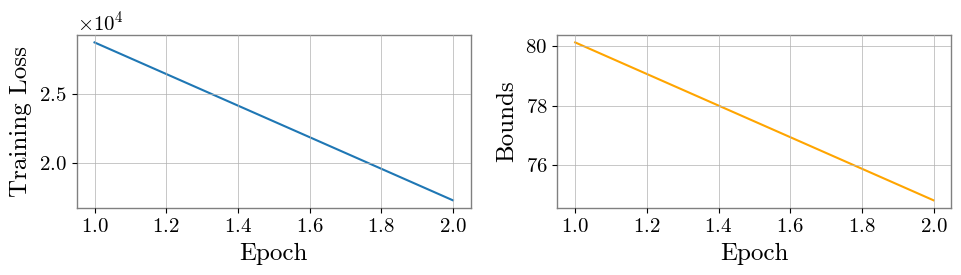

In [5]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout();

network_epsilon.bounds()

In [9]:
model.trainer.callback_metrics

{'train_loss': tensor(18478.1504),
 'bounds': tensor(83.1163),
 'training_epoch_average': tensor(18477.3320)}